In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import torch
import feather
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# local imports
import sys
sys.path.insert(1, '../')
from modules.util.augmentation import SegmentationAugmentation
from modules.util.util import window_image, lung_window, mediastinal_window
from modules.dsets import Covid2dSegmentationDataset, TrainingCovid2dSegmentationDataset

In [5]:
width_irc = (7,60,60)
lesion_ds = TrainingCovid2dSegmentationDataset(is_valid=None, width_irc=width_irc)
full_ct_ds = Covid2dSegmentationDataset()

2020-11-13 17:22:24,149 INFO     pid:44322 modules.dsets:180:__init__ <class 'modules.dsets.TrainingCovid2dSegmentationDataset'>: general mode, 197 uid's, 4971 index slices, 1237 lesions
2020-11-13 17:22:24,150 INFO     pid:44322 modules.dsets:221:__init__ <class 'modules.dsets.TrainingCovid2dSegmentationDataset'>: (7, 60, 60) width_irc
2020-11-13 17:22:24,172 INFO     pid:44322 modules.dsets:180:__init__ <class 'modules.dsets.Covid2dSegmentationDataset'>: general mode, 197 uid's, 4971 index slices, 1237 lesions


## Mask Overlay

Example CT slice with lesion mask overlay

In [6]:
lesion_ct, lesion_mask, lesion_uid, lesion_index = lesion_ds[0]
lesion_ct = lesion_ct[3:4].squeeze()
lesion_mask = lesion_mask.squeeze()
lesion_uid, lesion_index

('003', 88)

In [7]:
full_ct, full_mask, full_uid, full_index = full_ct_ds[24]
full_ct = full_ct[3:4].squeeze()
full_mask = full_mask.squeeze()
full_uid, full_index

('003', 88)

In [8]:
def overlay(ct,mask):
    ct = ct.clamp(-1000,1000)
    ct /= 2000
    ct += .5
    img = torch.zeros((ct.shape[0], ct.shape[1], 3))
    img[:,:,:] = ct.unsqueeze(-1)
    img[:,:,2] += mask # blue overlay
    img[:,:,2] *= .5
    return img

In [9]:
lesion_img = overlay(lesion_ct, lesion_mask)
full_img = overlay(full_ct, full_mask)

Areas with lesions are highlighted blue

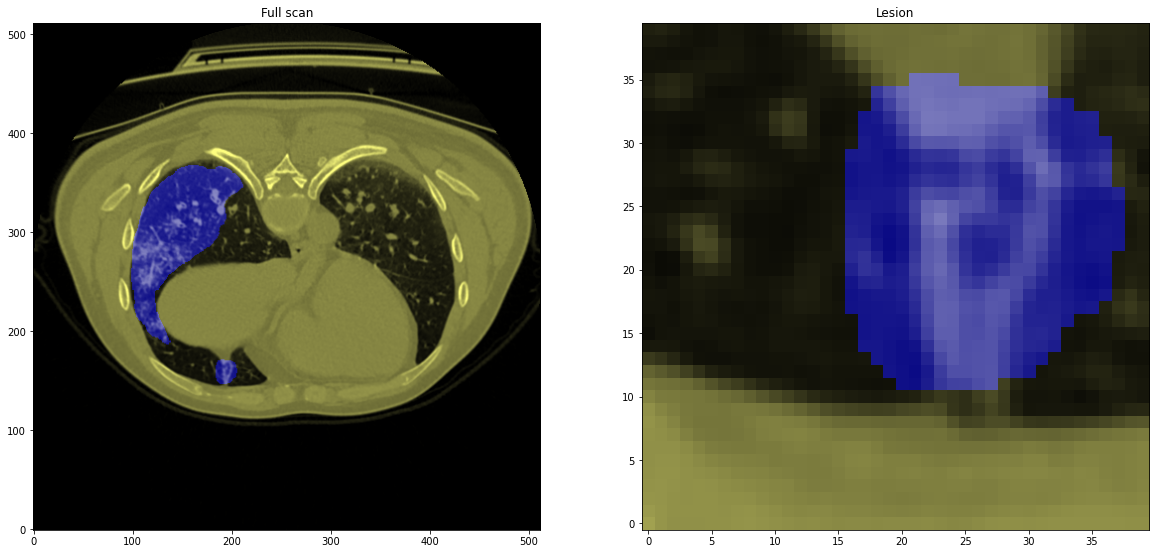

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].set_title('Full scan')
ax[1].set_title('Lesion')
ax[0].imshow(full_img, origin="lower")
ax[1].imshow(lesion_img, origin="lower")

## Augmentation

In [11]:
aug_dict = {
    'flip': True,
    'offset': .1,
    'scale': .2,
    'rotate': True,
    'noise': 25.
}

In [12]:
flip_aug = SegmentationAugmentation(flip=aug_dict['flip'])
offset_aug = SegmentationAugmentation(offset=aug_dict['offset'])
scale_aug = SegmentationAugmentation(scale=aug_dict['scale'])
rotate_aug = SegmentationAugmentation(rotate=aug_dict['rotate'])
noise_aug = SegmentationAugmentation(noise=aug_dict['noise'])
all_aug = SegmentationAugmentation(**aug_dict)

In [13]:
lesion_ct_flip, _ = flip_aug(lesion_ct[None,None], lesion_mask[None,None])
lesion_ct_offset, _ = offset_aug(lesion_ct[None,None], lesion_mask[None,None])
lesion_ct_scale, _ = scale_aug(lesion_ct[None,None], lesion_mask[None,None])
lesion_ct_rotate, _ = rotate_aug(lesion_ct[None,None], lesion_mask[None,None])
lesion_ct_noise, _ = noise_aug(lesion_ct[None,None], lesion_mask[None,None])
lesion_ct_aug, _ = all_aug(lesion_ct[None,None], lesion_mask[None,None])

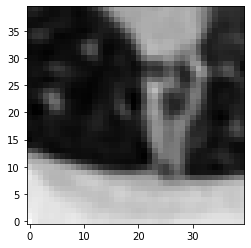

In [14]:
# Original
plt.imshow(lesion_ct, cmap="gray", origin="lower")

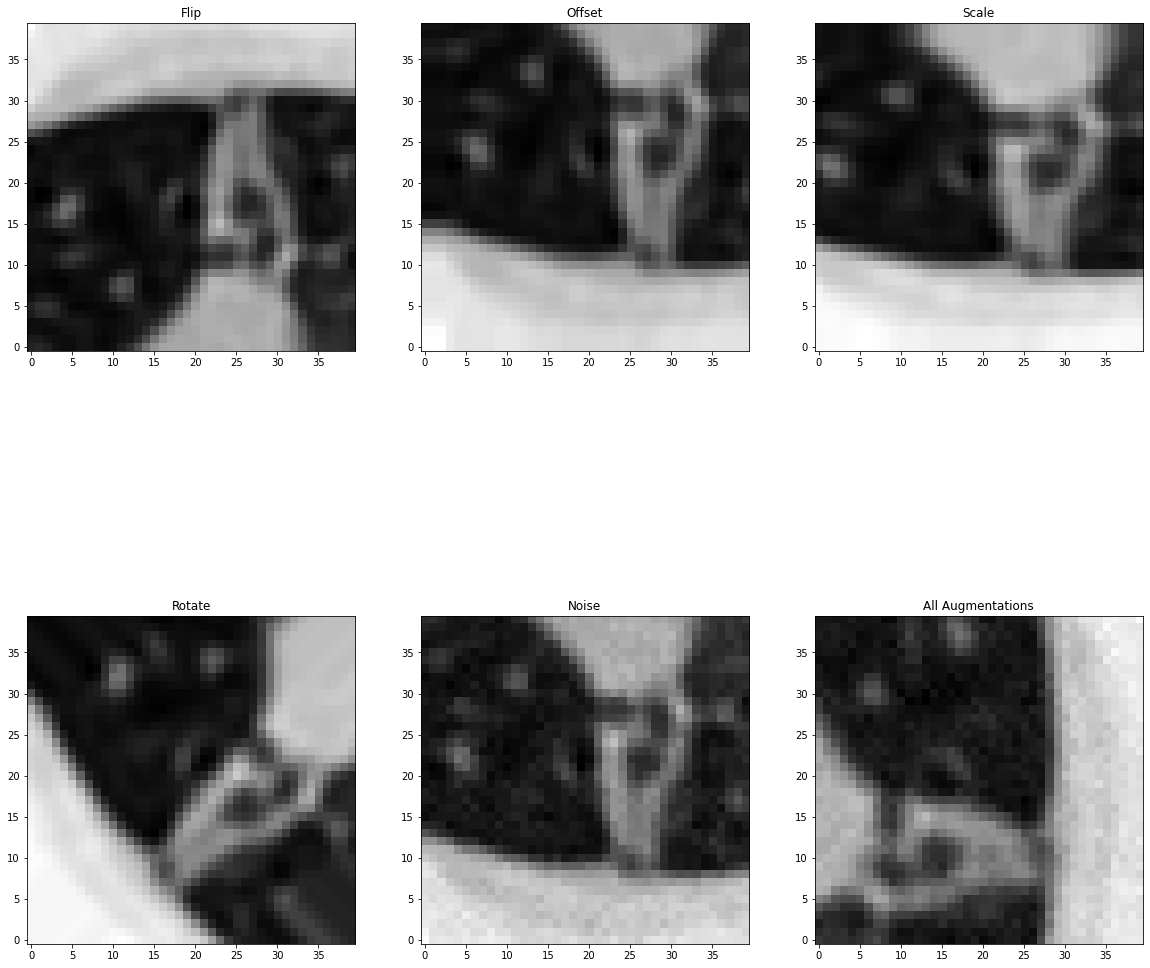

In [15]:
fig, ax = plt.subplots(2,3, figsize=(20,20))
ax[0][0].set_title('Flip')
ax[0][1].set_title('Offset')
ax[0][2].set_title('Scale')
ax[1][0].set_title('Rotate')
ax[1][1].set_title('Noise')
ax[1][2].set_title('All Augmentations')
ax[0][0].imshow(lesion_ct_flip.squeeze(0).squeeze(0), cmap="gray", origin="lower")
ax[0][1].imshow(lesion_ct_offset.squeeze(0).squeeze(0), cmap="gray", origin="lower")
ax[0][2].imshow(lesion_ct_scale.squeeze(0).squeeze(0), cmap="gray", origin="lower")
ax[1][0].imshow(lesion_ct_rotate.squeeze(0).squeeze(0), cmap="gray", origin="lower")
ax[1][1].imshow(lesion_ct_noise.squeeze(0).squeeze(0), cmap="gray", origin="lower")
ax[1][2].imshow(lesion_ct_aug.squeeze(0).squeeze(0), cmap="gray", origin="lower")